<a href="https://colab.research.google.com/github/meghamkpatel/Skunks_Skool/blob/main/INFO_6105/AutoML/Red_Wine_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Science Engineering
##Assignment 2 - 80 Cereals
*AutoML*
_______________________________________


##Abstract
Breakfast is the most important meal of the day! Cereals combined with milk are traditionally eaten food to kick start a healthy day. But how healthy is your cereal?  

Some companies promote their products for the health benefits that come from eating oat-based and high-fiber cereals. In the United States, cereals are often fortified with vitamins but can still lack many of the vitamins needed for a healthy breakfast. A significant proportion of cereals have a high sugar content ("sugar cereals" or "sugary cereals" in common parlance).

###Goal
In this notebook, we examine popular cereal brands and their nutritional facts including, calories, protein, fat, sodium, fiber, carbohydrates, sugars, potassium, and vitamins as well as external characteristics such as manufacturer, type, shelf level, weight, and number of cups per serving to predict ratings.

###Attributes
* name: Name of cereal
* mfr: Manufacturer of cereal
  * A = American Home Food Products;
  * G = General Mills
  * K = Kelloggs
  * N = Nabisco
  * P = Post
  * Q = Quaker Oats
  * R = Ralston Purina
* type:
  * cold
  * hot
* calories: calories per serving
* protein: grams of protein
* fat: grams of fat
* sodium: milligrams of sodium
* fiber: grams of dietary fiber
* carbo: grams of complex carbohydrates
* sugars: grams of sugars
* potass: milligrams of potassium
* vitamins: vitamins and minerals - 0, 25, or 100, indicating the typical percentage of FDA recommended
* shelf: display shelf (1, 2, or 3, counting from the floor)
* weight: weight in ounces of one serving
* cups: number of cups in one serving
* rating: a rating of the cereals (Possibly from Consumer Reports?)




###Initializing H2O...

In [47]:
#installing h2o
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [49]:
#importing all necessary libraries
%matplotlib inline  
import random, os, sys
import h2o
import pandas
import pprint
import operator
import matplotlib
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from tabulate import tabulate
from h2o.automl import H2OAutoML
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np

In [50]:
min_mem_size=6 
run_time=333

In [51]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

5


In [52]:
#installing dependencies
!pip install eli5
!pip install -q kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
#making a directory for kaggle api
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [56]:
#downloading and reading the 80 cereal dataset
! kaggle datasets list -s '80 cereals' # searching through kaggle with keyword '80 cereals'
! kaggle datasets download -d crawford/80-cereals 
!unzip 80-cereals.zip

ref                                                            title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
crawford/80-cereals                                            80 Cereals                                          2KB  2017-10-24 18:25:20          38896        526  0.85294116       
masoodhussain/80-cereals-nutrition-data-on-80-cereal-products  80 Cereals: Nutrition data on 80 cereal products    4KB  2017-11-14 10:09:45            169          3  0.1764706        
kagema/80-cereals                                              80 Cereals                                          2KB  2017-10-24 12:21:27             47          0  0.23529412       
shubhamsingh2001/crop-yield                                    crop yield  

In [57]:
h2o.init(strict_version_check=False) # start h2o

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 34 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,1 month and 6 days
H2O_cluster_name:,H2O_from_python_unknownUser_ujxj0v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.033 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [58]:
# set this to True if interactive (matplotlib) plots are desired
interactive = True
if not interactive: matplotlib.use('Agg', warn=False)
import matplotlib.pyplot as plt

In [59]:
#Viewing data in the file 
data = h2o.import_file("cereal.csv")
data.shape
data.describe()
data.head()


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:77
Cols:16

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
type,string,enum,enum,int,int,int,int,real,real,int,int,int,int,real,real,real
mins,NaN,,,50.0,1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,1.0,0.5,0.25,18.042851
mean,NaN,,,106.8831168831169,2.545454545454545,1.0129870129870129,159.67532467532473,2.1519480519480525,14.597402597402601,6.922077922077923,96.07792207792208,28.246753246753244,2.2077922077922074,1.0296103896103896,0.8210389610389608,42.665704987012965
maxs,NaN,,,160.0,6.0,5.0,320.0,14.0,23.0,15.0,330.0,100.0,3.0,1.5,1.5,93.704912
sigma,NaN,,,19.484119056820845,1.094789748445534,1.0064725594803927,83.83229524009316,2.3833639643872226,4.278956280325907,4.4448853924193585,71.2868125092621,22.342522500566307,0.832524100135788,0.15047679973689213,0.23271613844691388,14.047288743735217
zeros,0,,,0,0,27,9,19,0,7,0,8,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,100% Bran,N,C,70.0,4.0,1.0,130.0,10.0,5.0,6.0,280.0,25.0,3.0,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120.0,3.0,5.0,15.0,2.0,8.0,8.0,135.0,0.0,3.0,1.0,1.0,33.983679
2,All-Bran,K,C,70.0,4.0,1.0,260.0,9.0,7.0,5.0,320.0,25.0,3.0,1.0,0.33,59.425505


name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
100% Bran,N,C,70,4,1,130,10,5,6,280,25,3,1,0.33,68.403
100% Natural Bran,Q,C,120,3,5,15,2,8,8,135,0,3,1,1,33.9837
All-Bran,K,C,70,4,1,260,9,7,5,320,25,3,1,0.33,59.4255
All-Bran with Extra Fiber,K,C,50,4,0,140,14,8,0,330,25,3,1,0.5,93.7049
Almond Delight,R,C,110,2,2,200,1,14,8,-1,25,3,1,0.75,34.3848
Apple Cinnamon Cheerios,G,C,110,2,2,180,1.5,10.5,10,70,25,1,1,0.75,29.5095
Apple Jacks,K,C,110,2,0,125,1,11,14,30,25,2,1,1,33.1741
Basic 4,G,C,130,3,2,210,2,18,8,100,25,3,1.33,0.75,37.0386
Bran Chex,R,C,90,2,1,200,4,15,6,125,25,1,1,0.67,49.1203
Bran Flakes,P,C,90,3,0,210,5,13,5,190,25,3,1,0.67,53.3138


In [60]:
train, test = data.split_frame(seed = 1234, destination_frames = ["train.hex", "test.hex"])


In [61]:
# assign target and inputs for logistic regression
y = 'rating'
X = [name for name in train.columns if name != y]
print(y)
print(X)

rating
['name', 'mfr', 'type', 'calories', 'protein', 'fat', 'sodium', 'fiber', 'carbo', 'sugars', 'potass', 'vitamins', 'shelf', 'weight', 'cups']


###Regression

In [62]:
aml = H2OAutoML(max_runtime_secs=run_time,exclude_algos = ['DeepLearning'])

In [63]:
aml.train(x=X,y=y,training_frame=train)  # Change training_frame=train

AutoML progress: |
19:45:32.48: _train param, Dropping bad and constant columns: [name]


19:45:32.693: _train param, Dropping bad and constant columns: [name]


19:45:33.97: _train param, Dropping bad and constant columns: [name]
19:45:33.97: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 54.0.
19:45:33.99: _train param, Dropping unused columns: [name]
19:45:33.214: _train param, Dropping bad and constant columns: [name]

█
19:45:34.24: _train param, Dropping bad and constant columns: [name]

██
19:45:35.277: _train param, Dropping bad and constant columns: [name]

██
19:45:36.238: _train param, Dropping bad and constant columns: [name]

█
19:45:37.281: _train param, Dropping bad and constant columns: [name]

█
19:45:37.822: _train param, Dropping unused columns: [name]
19:45:37.941: _train param, Dropping unused columns: [name]
19:45:38.65: _train param, Dropping bad and constant columns: [name]

██


In [65]:
print(aml.leaderboard)

model_id                                                    rmse       mse      mae      rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_1_AutoML_3_20221025_194532  1.69205   2.86302  1.23099  0.0408406                   2.86302
StackedEnsemble_BestOfFamily_6_AutoML_3_20221025_194532  1.72741   2.98393  1.35977  0.0438537                   2.98393
GLM_1_AutoML_3_20221025_194532                           1.78334   3.1803   1.42511  0.0474489                   3.1803
StackedEnsemble_BestOfFamily_4_AutoML_3_20221025_194532  3.18125  10.1203   2.47811  0.0854998                  10.1203
StackedEnsemble_BestOfFamily_3_AutoML_3_20221025_194532  3.38008  11.425    2.4918   0.085515                   11.425
StackedEnsemble_AllModels_5_AutoML_3_20221025_194532     3.48911  12.1739   2.60717  0.0899399                  12.1739
StackedEnsemble_AllModels_2_AutoML_3_20221025_194532     3.49292  12.2005   2.59889  0.0906441                  12.2005
StackedEnsemble_BestOfFamily_2_AutoML_

###Answer Questions using Leading Model
**1. Is the relationship significant?**
 

In [74]:
best_model = h2o.get_model(aml.leaderboard[2,'model_id'])
best_model.algo

'glm'

In [67]:
best_model.r2(train=True)

0.9904745140952762

In [68]:
print(best_model.r2(valid=True))

None


In [69]:
print(best_model.r2(xval = True))

0.9779243356240078


In [75]:
perf = aml.leader.model_performance(test)
perf

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 2.1859933385079184
RMSE: 1.4785105134925212
MAE: 1.0589094413537428
RMSLE: 0.02585770048910259
Mean Residual Deviance: 2.1859933385079184
R^2: 0.9921724653803159
Null degrees of freedom: 22
Residual degrees of freedom: 21
Null deviance: 7555.614683720491
Residual deviance: 50.27784678568212
AIC: 89.25879040276615

According to R^2, we see a high correlation in our training model. In a General Linear Model, having a a R^2 value close to one suggests there is a significant relationship.

**2. Are any model assumptions violated?**

**3. Is there any multicollinearity in the model?**

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


[PartialDependence: Partial Dependence Plot of model GLM_1_AutoML_3_20221025_194532 on column 'mfr'.
mfr    mean_response    stddev_response    std_error_mean_response
-----  ---------------  -----------------  -------------------------
A      40.7795          11.0361            1.50183
G      39.84            11.0361            1.50183
K      40.9413          11.0361            1.50183
N      42.2897          11.0361            1.50183
P      40.6927          11.0361            1.50183
Q      39.938           11.0361            1.50183
R      40.8968          11.0361            1.50183]

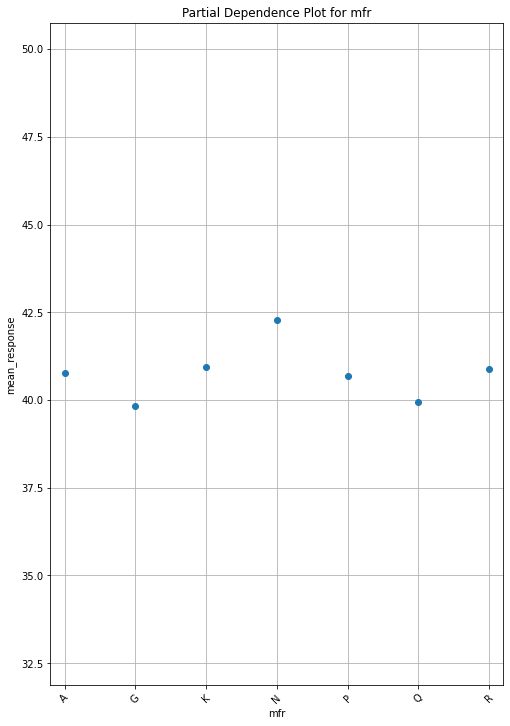

In [82]:
best_model.partial_plot(train, cols = ['mfr'], plot = True, plot_stddev = False)

**4. In the multivariate models are predictor variables independent of all the other predictor variables?**

**5. In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

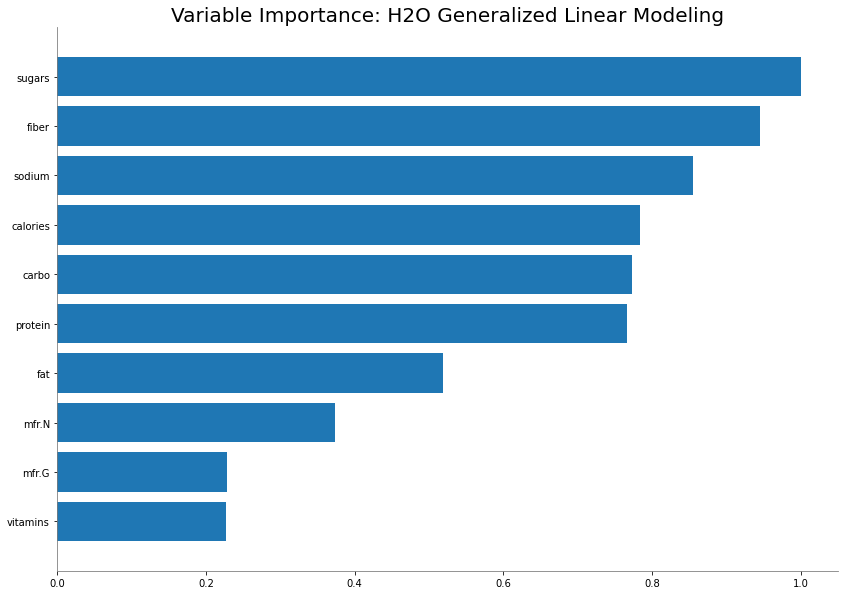

<Figure size 432x288 with 0 Axes>

In [72]:
best_model.varimp_plot()

* Is the relationship significant?

* Are any model assumptions violated?

* Is there any multicollinearity in the model?

* In the multivariate models are predictor variables independent of all the other predictor variables?

* In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

* Does the model make sense?

* Does regularization help?

* Which independent variables are significant?

* Which hyperparameters are important?

* Coding professionalism?